### Preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [2]:
#Load in data set
ABBdata = pd.read_csv("C:/Users/zhaoy/Documents/ECON611_ML/AirBnB price pred.csv")
#View data
ABBdata.head()

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,7/9/2020,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [3]:
#Places with more minimum nights than 365 are not short term listings
ABBdata = ABBdata[ABBdata['minimum_nights']<365]

#Get Unique City names
cities = ABBdata.city.unique()
#Make cities into a dataframe that we can work with
cities = pd.DataFrame(cities, columns =['CityName'])

#Create a set of city indicators
for i, row in enumerate(cities.values):
    citydum = cities.CityName[i]==ABBdata.city
    colname = cities.CityName[i]
    ABBdata[colname]=citydum

#Use log price - need to add 1 before doing so because ln(0) doesnt exist
ABBdata['price']=np.log(ABBdata['price']+1)

#Create substring
sub = "Entire"
#I call this "sub" because I will search for this substring
ABBdata["Entire"]= ABBdata["room_type"].str.find(sub, 0)

#Create a "true" or "false" that it is the entire place
ABBdata["Entire"] = ABBdata.Entire>=0
#Assign 1 to "True" and 0 to "False"
ABBdata["Entire"] = ABBdata["Entire"].astype(int)

#look at owner descriptions. Transform everything to lower case to make text easier to process
# (the operators we use are case-sensitive) (PRE PROCESSING)
ABBdata['name'] = ABBdata['name'].str.lower()

#The word "minutes" is often used to say that the listing is very close to something desirable, like downtown, museums etc.
sub = "minutes"
ABBdata["Minutes"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Minutes"] = ABBdata.Minutes>=0
ABBdata["Minutes"]=ABBdata["Minutes"].astype(int)
#CLeanliness of the place, etc.
sub = "clean"
ABBdata["Clean"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Clean"] = ABBdata.Clean>=0
ABBdata["Clean"] = ABBdata["Clean"].astype(int)
sub = "convenient"
ABBdata["Convenient"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Convenient"] = ABBdata.Convenient>=0
ABBdata["Convenient"] = ABBdata["Convenient"].astype(int)
sub = "charm"
ABBdata["Charm"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Charm"] = ABBdata.Charm>=0
ABBdata["Charm"] = ABBdata["Charm"].astype(int)
sub = "cozy"
ABBdata["Cozy"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Cozy"] = ABBdata.Cozy>=0
ABBdata["Cozy"] = ABBdata["Cozy"].astype(int)
sub = "comf"
ABBdata["Comfortable"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Comfortable"] = ABBdata.Comfortable>=0
ABBdata["Comfortable"] = ABBdata["Comfortable"].astype(int)

In [4]:
ABBdata.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city', 'Asheville', 'Austin', 'Boston',
       'Broward County', 'Cambridge', 'Chicago', 'Clark County', 'Columbus',
       'Denver', 'Hawaii', 'Jersey City', 'Los Angeles', 'Nashville',
       'New Orleans', 'New York City', 'Oakland', 'Pacific Grove', 'Portland',
       'Rhode Island', 'Salem', 'San Clara Country', 'San Diego',
       'San Francisco', 'San Mateo County', 'Santa Cruz County', 'Seattle',
       'Twin Cities MSA', 'Washington D.C.', 'Entire', 'Minutes', 'Clean',
       'Convenient', 'Charm', 'Cozy', 'Comfortable'],
      dtype='object')

In [5]:
#Drop Columns we aren't going to use
ABBdata = ABBdata.drop(['id', 'name', 'host_name', 'city', 'host_id','neighbourhood', 'neighbourhood_group', 'latitude', 'longitude', 'room_type', 'last_review'], axis=1)
ABBdata = ABBdata.dropna(axis=0, how='any')
ABBdata.head()

#Sort data on something other than city name - sorting on city name means for some folds we wont have any observations for some cities
ABBdata = ABBdata.sort_values(by=['price'])

#Create our Y and X data, which we will input into sci-kit learn
ydata = pd.DataFrame(ABBdata.price)
xdata = pd.DataFrame(ABBdata)
xdata = xdata.drop(['price'], axis=1)

In [6]:
xdata = xdata.reset_index(drop=True)
xdata

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Asheville,Austin,Boston,Broward County,Cambridge,...,Seattle,Twin Cities MSA,Washington D.C.,Entire,Minutes,Clean,Convenient,Charm,Cozy,Comfortable
0,2,143,4.21,24,171,False,False,False,False,False,...,False,False,False,0,0,0,0,0,0,0
1,1,16,0.45,3,0,False,False,False,False,False,...,False,False,False,0,0,0,0,0,0,0
2,2,118,3.55,24,0,False,False,False,False,False,...,False,False,False,0,0,0,0,0,0,0
3,2,97,2.91,24,163,False,False,False,False,False,...,False,False,False,0,0,0,0,0,0,0
4,1,2,0.24,5,0,False,False,False,False,False,...,False,False,False,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177259,2,4,0.62,4,258,True,False,False,False,False,...,False,False,False,1,0,0,0,0,0,0
177260,3,5,0.22,166,0,False,False,False,False,False,...,False,False,False,1,0,0,0,1,0,0
177261,3,4,0.10,166,0,False,False,False,False,False,...,False,False,False,1,0,0,0,0,0,0
177262,2,5,1.55,4,253,True,False,False,False,False,...,False,False,False,1,0,0,0,0,0,0


In [7]:
#Convert the pandas data frame to a numpy array to use scikit learn
xdatan = xdata.values
ydatan = ydata.values

In [8]:
# Initial model evaluation
scores = cross_val_score(LinearRegression(), xdatan, ydatan, cv=5, scoring='neg_mean_squared_error')
scores = -scores
print("Cross Validation")
print("Average MSE %0.2f std of MSE %0.2f" % (scores.mean(), scores.std()))

Cross Validation
Average MSE 0.66 std of MSE 0.59


### 1(a)

In [9]:
# Getting the MSE score from the original model
baseline_scores = cross_val_score(LinearRegression(), xdatan, ydatan.ravel(), cv=5, scoring='neg_mean_squared_error')
baseline_mse = -baseline_scores.mean()
baseline_mse

0.6618793313276718

In [10]:
# Creating a new variable for all exisiting features
feature_names = xdata.columns
performance_impact = []

for feature in feature_names:
    # Drop the feature
    xdata_reduced = xdata.drop(columns=[feature])
    xdatan_reduced = xdata_reduced.values
    
    # Perform cross-validation on the model with the reduced feature set
    scores_reduced = cross_val_score(LinearRegression(), xdatan_reduced, ydatan.ravel(), cv=5, scoring='neg_mean_squared_error')
    mse_reduced = -scores_reduced.mean()
    
    # Record the performance impact
    performance_impact.append((feature, mse_reduced))


In [11]:
performance_impact

[('minimum_nights', 0.6714744666047101),
 ('number_of_reviews', 0.6598732294972874),
 ('reviews_per_month', 0.6717957769474752),
 ('calculated_host_listings_count', 0.6618587822174785),
 ('availability_365', 0.6673620955233351),
 ('Asheville', 0.6618793313276814),
 ('Austin', 0.6618793313276777),
 ('Boston', 0.661879331327676),
 ('Broward County', 0.6618793313276787),
 ('Cambridge', 0.6618793313276766),
 ('Chicago', 0.6618793313276802),
 ('Clark County', 0.6618793313276795),
 ('Columbus', 0.6618793313276778),
 ('Denver', 0.661879331327681),
 ('Hawaii', 0.661879331327674),
 ('Jersey City', 0.6618793313276811),
 ('Los Angeles', 0.6618793313276751),
 ('Nashville', 0.6618793313276814),
 ('New Orleans', 0.6618793313276782),
 ('New York City', 0.6618793313276746),
 ('Oakland', 0.6618793313276798),
 ('Pacific Grove', 0.6618793313276786),
 ('Portland', 0.6618793313276792),
 ('Rhode Island', 0.6618793313276811),
 ('Salem', 0.6618793313276783),
 ('San Clara Country', 0.6618793313276823),
 ('San 

In [91]:
# Sort features by their impact on MSE (lower is better)
sorted_features_by_impact = sorted(performance_impact, key=lambda x: x[1])

# Identify features whose removal improves model performance
improved_features = [(feature, mse) for feature, mse in sorted_features_by_impact if mse < baseline_mse]

print("Features whose removal improves performance:", improved_features)

Features whose removal improves performance: [('number_of_reviews', 0.6598732294972874), ('Charm', 0.6616153457252011), ('calculated_host_listings_count', 0.6618587822174785)]


In [112]:
mse_reduced

0.6631722563677425

In [102]:
# Dropping suggested columns
xdata_new = xdata.drop(['number_of_reviews', 'Charm', 'calculated_host_listings_count'], axis=1)

In [103]:
xdatan_new = xdata_new.values

In [106]:
xdata_new.columns

Index(['minimum_nights', 'reviews_per_month', 'availability_365', 'Asheville',
       'Austin', 'Boston', 'Broward County', 'Cambridge', 'Chicago',
       'Clark County', 'Columbus', 'Denver', 'Hawaii', 'Jersey City',
       'Los Angeles', 'Nashville', 'New Orleans', 'New York City', 'Oakland',
       'Pacific Grove', 'Portland', 'Rhode Island', 'Salem',
       'San Clara Country', 'San Diego', 'San Francisco', 'San Mateo County',
       'Santa Cruz County', 'Seattle', 'Twin Cities MSA', 'Washington D.C.',
       'Entire', 'Minutes', 'Clean', 'Convenient', 'Cozy', 'Comfortable'],
      dtype='object')

In [109]:
# Evaluate model performance (e.g., through cross-validation)
scores3 = cross_val_score(LinearRegression(), xdatan_new, ydatan.ravel(), cv=5, scoring='neg_mean_squared_error')
scores3 = -scores3
print("Cross Validation")
print("Average MSE %0.5f std of MSE %0.2f" % (scores3.mean(), scores3.std()))

Cross Validation
Average MSE 0.65950 std of MSE 0.58


### 2(a)

In [24]:
import numpy as np

# Setting random seed
np.random.seed(42)

def generate_sample(N=500):
    # Parameters
    mu_2, sigma_2 = 1, np.sqrt(2)
    mu_e, sigma_e = 0, np.sqrt(2)
    mu_u, sigma_u = 0, np.sqrt(3)
    gamma_0, gamma_1 = 0.5, 1
    beta_0, beta_1, beta_2 = 0.5, 1, 1.5
    
    # Generate X_i2
    X_i2 = np.random.normal(mu_2, sigma_2, N)
    
    # Generate e_i for X_i1
    e_i = np.random.normal(mu_e, sigma_e, N)
    
    # Calculate X_i1
    X_i1 = gamma_0 + gamma_1 * X_i2 + e_i
    
    # Generate u_i for y_i
    u_i = np.random.normal(mu_u, sigma_u, N)
    
    # Calculate y_i
    y_i = beta_0 + beta_1 * X_i1 + beta_2 * X_i2 + u_i
    
    # Combine into a single array for X, including a column of ones for the intercept
    X = np.column_stack((np.ones(N), X_i1, X_i2))
    
    return y_i, X


In [25]:
# To generate N observations
y_i, X = generate_sample(N=500)

### 2(b)

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error

# Parameters
S = 1000  # Number of samples to generate
k = 5  # Number of folds in k-fold CV
mse_scores = np.zeros(S)  # Vector to store MSEs

for s in range(S):
    # Setting random seed
    np.random.seed(42)
    # Generate a sample
    y_i, X = generate_sample(N=500)
    
    # Linear Regression model
    model = LinearRegression()
    
    # k-fold CV to calculate MSE
    mse = cross_val_score(model, X, y_i, cv=k, scoring=make_scorer(mean_squared_error)).mean()
    
    # Store the MSE
    mse_scores[s] = mse

In [33]:
mse_scores[s]

3.064289472470833

### 2(c)

In [38]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import KFold

# Parameters
mse_scores_ridge = np.zeros(S)  # Vector to store MSEs
optimal_lambdas = np.zeros(S)  # Vector to store optimal penalty values

for s in range(S):
    # Setting random seed
    np.random.seed(42)
    # Generate a sample
    y_i, X = generate_sample(N=500)
    
    # Define a range of alpha (lambda) values to explore
    alphas = np.logspace(-6, 6, 13)
    
    # Ridge Regression with built-in cross-validation to find the optimal alpha
    model_ridge_cv = RidgeCV(alphas=alphas, cv=k, scoring='neg_mean_squared_error')
    model_ridge_cv.fit(X, y_i)
    
    # The optimal alpha (lambda) and corresponding MSE
    optimal_lambda = model_ridge_cv.alpha_
    optimal_mse = mean_squared_error(y_i, model_ridge_cv.predict(X))
    
    # Store the optimal lambda and MSE
    mse_scores_ridge[s] = optimal_mse
    optimal_lambdas[s] = optimal_lambda


In [39]:
mse_scores_ridge[s]

3.0296840257481064

In [40]:
optimal_lambdas[s]

1.0

### 2(d)

In [44]:
from sklearn.linear_model import LassoCV

# Parameters
mse_scores_lasso = np.zeros(S)  # Vector to store MSEs
optimal_lambdas_lasso = np.zeros(S)  # Vector to store optimal penalty values (lambda)

for s in range(S):
    # Setting random seed
    np.random.seed(42)
    # Generate a sample
    y_i, X = generate_sample(N=500)
    
    # Lasso Regression with built-in cross-validation to find the optimal alpha (lambda)
    model_lasso_cv = LassoCV(cv=k, random_state=0, alphas=np.logspace(-6, 2, 100))
    model_lasso_cv.fit(X, y_i)
    
    # The optimal alpha (lambda) and corresponding MSE
    optimal_lambda_lasso = model_lasso_cv.alpha_
    optimal_mse_lasso = mean_squared_error(y_i, model_lasso_cv.predict(X))
    
    # Store the optimal lambda and MSE
    mse_scores_lasso[s] = optimal_mse_lasso
    optimal_lambdas_lasso[s] = optimal_lambda_lasso


In [45]:
mse_scores_lasso[s]

3.029680234768098

In [46]:
optimal_lambdas_lasso[s]

1e-06

### 2(e)

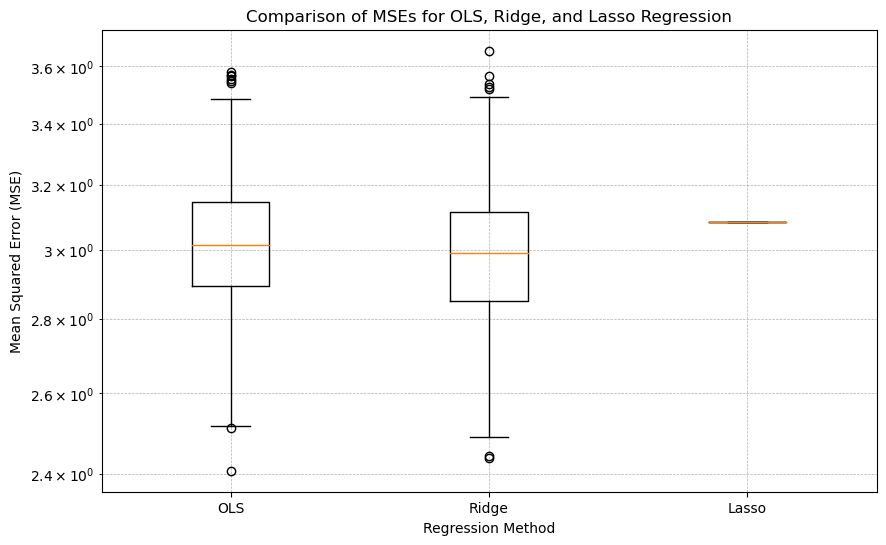

In [16]:
import matplotlib.pyplot as plt

# Plot
data_to_plot = [mse_scores, mse_scores_ridge, mse_scores_lasso]
labels = ['OLS', 'Ridge', 'Lasso']

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=labels)
plt.title('Comparison of MSEs for OLS, Ridge, and Lasso Regression')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Regression Method')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')  # Optional: Use logarithmic scale for better visibility if needed
plt.show()
